# Detecteur de SPAM


## EDA

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go


from sklearn.model_selection import train_test_split

import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import re


In [2]:
df = pd.read_csv("src/spam.csv", encoding="Windows-1252")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.describe(include="all")

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [4]:
def join_text(texts):
    result = ""
    for text in texts:
        if(str(text).lower() != "nan"):
            result = ", ".join([result, str(text)])
    
    return result[2:]

cols = ['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df['text'] = df[cols].apply(lambda row: join_text(row), axis=1)
df = df.drop(cols, axis=1).rename(columns={"v1": "category"})
df.head()

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


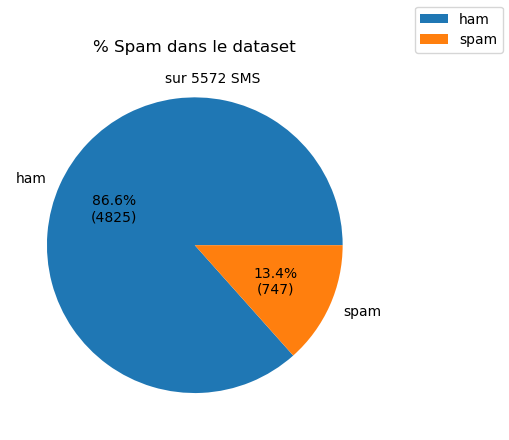

In [5]:
def format_value(x):
    return '{:.1f}%\n({:.0f})'.format(x, len(df)*x/100)

plt.pie(df.category.value_counts(), labels=df.category.value_counts().index, autopct=format_value)
plt.figlegend(df.category.value_counts().index)
plt.title("% Spam dans le dataset")
plt.text(-0.2, 1.1, f"sur {len(df)} SMS")
plt.show()

## Preprocessing

Pour le prepocessing, on a de meilleurs résultats sans lematizer et sans enlever les stop words. On garde aussi cependant la ponctuation car elle peut être utile pour détecter les spams.

In [6]:
nlp = en_core_web_sm.load()

In [7]:
def cleanText(text):
    text = re.sub(' +', ' ', text).lower().strip()
    doc = nlp(text)
    #cleantext = " ".join([token.lemma_ for token in doc if (token.text not in STOP_WORDS) or (token.lemma_ not in STOP_WORDS)])
    #cleantext = " ".join([token.lemma_ for token in doc])
    cleantext = " ".join([token.lower_ for token in doc])
    return cleantext

In [8]:
df["clean_text"] = df["text"].apply(cleanText)
df.head()

,category,text,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point , crazy .. available onl..."
1,ham,Ok lar... Joking wif u oni...,ok lar ... joking wif u oni ...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor ... u c already then sa...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i do n't think he goes to usf , he lives a..."


In [9]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(1000, filters="")
tokenizer.fit_on_texts(df["clean_text"])
df["text_encoded"] = tokenizer.texts_to_sequences(df["clean_text"])
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))
df = df[df["len_text"] != 0]
df.head()

,category,text,clean_text,text_encoded,len_text
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point , crazy .. available onl...","[63, 474, 827, 5, 781, 19, 678, 81, 14, 105, 1...",18
1,ham,Ok lar... Joking wif u oni...,ok lar ... joking wif u oni ...,"[61, 340, 10, 475, 11, 10]",6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[62, 492, 14, 30, 7, 782, 930, 3, 203, 649, 27...",21
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor ... u c already then sa...,"[11, 260, 163, 32, 389, 10, 11, 178, 166, 72, ...",12
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i do n't think he goes to usf , he lives a...","[988, 2, 20, 48, 118, 78, 493, 3, 989, 5, 78, ...",14


In [10]:
df["category_bool"] = df["category"].apply(lambda x: 1.0 if x == "spam" else 0.0)
df.head()

,category,text,clean_text,text_encoded,len_text,category_bool
0,ham,"Go until jurong point, crazy.. Available only ...","go until jurong point , crazy .. available onl...","[63, 474, 827, 5, 781, 19, 678, 81, 14, 105, 1...",18,0.0
1,ham,Ok lar... Joking wif u oni...,ok lar ... joking wif u oni ...,"[61, 340, 10, 475, 11, 10]",6,0.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,"[62, 492, 14, 30, 7, 782, 930, 3, 203, 649, 27...",21,1.0
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor ... u c already then sa...,"[11, 260, 163, 32, 389, 10, 11, 178, 166, 72, ...",12,0.0
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i do n't think he goes to usf , he lives a...","[988, 2, 20, 48, 118, 78, 493, 3, 989, 5, 78, ...",14,0.0


In [11]:
# Pad sequences to have the same length
text_pad = tf.keras.preprocessing.sequence.pad_sequences(df.text_encoded, padding="post")

# Train Test Split
X_train, X_val, Y_train, Y_val = train_test_split(text_pad, df.category_bool, test_size=0.3, stratify=df.category_bool, random_state=0)

train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

train_batch = train.shuffle(len(train)).batch(128)
val_batch = val.shuffle(len(val)).batch(128)

## Modèle

In [12]:
vocab_size = len(tokenizer.word_index)
embedding_dim=32

model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, name="embedding", input_length=df["len_text"].max()),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 179, 32)           309376    
                                                                 
 flatten (Flatten)           (None, 5728)              0         
                                                                 
 dense (Dense)               (None, 1024)              5866496   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                1

Pour les métriques, on prendra :

- la precision : on ne veut pas qualifier comme SPAM un message qui ne l'est pas
- le recall : on souhaite trouver un maximum de SPAM possible
- le F1-score : qui est une subtile combinaison entre la precision et le rappel (le nb de spam détecter sur le nb total de spam) mais qui ne compte pas les vrai négatifs. Comme nos classes sont déséquilibrer, il est très intéressant.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[
                  tf.keras.metrics.F1Score(average="weighted", name="f1_score"), 
                  tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall")])

## Train

In [14]:
history = model.fit(
    train_batch,
    validation_data=val_batch,
    epochs=200
)

Epoch 1/200
31/31 [==============================] - 3s 54ms/step - loss: 0.3347 - f1_score: 0.2365 - precision: 0.5000 - recall: 0.0326 - val_loss: 0.1938 - val_f1_score: 0.2359 - val_precision: 1.0000 - val_recall: 0.5605
Epoch 2/200
31/31 [==============================] - 1s 46ms/step - loss: 0.1027 - f1_score: 0.2365 - precision: 0.9350 - recall: 0.8544 - val_loss: 0.0639 - val_f1_score: 0.2359 - val_precision: 0.9851 - val_recall: 0.8924
Epoch 3/200
31/31 [==============================] - 1s 47ms/step - loss: 0.0368 - f1_score: 0.2365 - precision: 0.9819 - recall: 0.9349 - val_loss: 0.0629 - val_f1_score: 0.2359 - val_precision: 0.9853 - val_recall: 0.9013
Epoch 4/200
31/31 [==============================] - 1s 47ms/step - loss: 0.0165 - f1_score: 0.2365 - precision: 0.9845 - recall: 0.9751 - val_loss: 0.0722 - val_f1_score: 0.2359 - val_precision: 0.9950 - val_recall: 0.8969
Epoch 5/200
31/31 [==============================] - 1s 46ms/step - loss: 0.0054 - f1_score: 0.2386 - pr

In [15]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                      ),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                      )
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [16]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["precision"],
                          name="Training precision",
                          mode="lines",
                      ),
                      go.Scatter(
                          y=history.history["val_precision"],
                          name="Validation precision",
                          mode="lines",
                      )
])
fig.update_layout(
    title='Training and val precision across epochs',
    xaxis_title='epochs',
    yaxis_title='Precision'    
)
fig.show()

In [17]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["recall"],
                          name="Training recall",
                          mode="lines",
                      ),
                      go.Scatter(
                          y=history.history["val_recall"],
                          name="Validation recall",
                          mode="lines",
                      )
])
fig.update_layout(
    title='Training and val recall across epochs',
    xaxis_title='epochs',
    yaxis_title='Precision'    
)
fig.show()

In [18]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["f1_score"],
                          name="Training f1-score",
                          mode="lines",
                      ),
                      go.Scatter(
                          y=history.history["val_f1_score"],
                          name="Validation f1-score",
                          mode="lines",
                      )
])
fig.update_layout(
    title='Training and val F1-score across epochs',
    xaxis_title='epochs',
    yaxis_title='F1-score'    
)
fig.show()

53/53 [==============================] - 0s 6ms/step


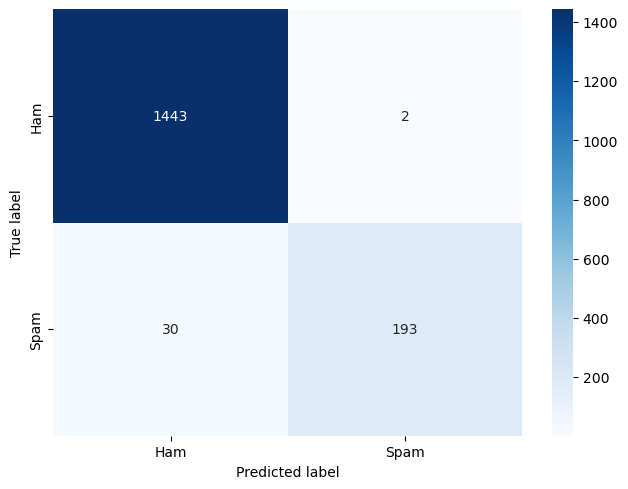

In [19]:
y_pred=model.predict(X_val)
con_mat = tf.math.confusion_matrix(labels=Y_val, predictions=y_pred).numpy()

# con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat,
                     index = ["Ham", "Spam"], 
                     columns = ["Ham", "Spam"])

# figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues, fmt=".0f")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Conclusion

Avec ce modèle, on arrive à un résultat satisfaisant où ~100% des SMS considérés comme SPAM le sont réelement et ~90% des SPAM sont détectés.

Le F1-score qui est une moyenne harmonique entre ceux deux metriques est elle de 86%.

Ce sont de bon scores car on préfère laisser passé quelques SPAM que de considérer de vrai meassage comme SPAM et que l'utilisateur ne les voient pas.
